Can we predict housing prices based on the features?

How are housing price and location attributes correlated?

What is the overall picture of the USA housing prices w.r.t. locations?

Do house attributes (bedroom, bathroom count) strongly correlate with the price? 

Are there any hidden patterns?

In [100]:
import warnings
from glob import glob
import numpy as np
import pandas as pd
import math
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import wqet_grader
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
#wqet_grader.init("Project 2 Assessment")

# Data Wrangling

In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Dropping Columns that do contribute to price
    df =df.drop(columns = ["prev_sold_date", "status"])
    
    #Dropping columns with Low Correlation
    df =df.drop(columns =["city","zip_code"])
    
    #Removing outliers in Price
    low, high = df["price"].quantile([0.1,0.9]).head()
    df_mask = df["price"].between(low,high)
    df = df[df_mask]
    
    #Removing outliers in Bath
    low, high = df["bath"].quantile([0.1,0.9]).head()
    df_mask = df["bath"].between(low,high)
    df = df[df_mask]
    
    #Removing outliers in Bed
    low, high = df["bed"].quantile([0.2,0.8]).head()
    df_mask = df["bed"].between(low,high)
    df = df[df_mask]
    
    #Removing outliers in house_size
    low, high = df["house_size"].quantile([0.1,0.9]).head()
    df_mask = df["house_size"].between(low,high)
    df = df[df_mask]
    
    #Removing outliers in acre_lot
    low, high = df["acre_lot"].quantile([0.1,0.9]).head()
    df_mask = df["acre_lot"].between(low,high)
    df = df[df_mask]
    
    return df

In [4]:
df = wrangle("realtor-data.zip.csv")

In [5]:
df.describe()

,bed,bath,acre_lot,house_size,price
count,182335.000000,182335.000000,182335.000000,182335.000000,1.823350e+05
mean,3.178627,2.171300,0.444123,1699.444018,4.513090e+05
std,0.630495,0.738633,0.442357,457.277383,2.498926e+05
min,2.000000,1.000000,0.060000,978.000000,1.350000e+05
25%,3.000000,2.000000,0.150000,1320.000000,2.750000e+05
50%,3.000000,2.000000,0.260000,1634.000000,3.850000e+05
75%,4.000000,3.000000,0.550000,2030.000000,5.650000e+05
max,4.000000,4.000000,2.080000,2750.000000,1.650000e+06


In [6]:
len(df)

182335

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182335 entries, 3 to 904918
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   bed         182335 non-null  float64
 1   bath        182335 non-null  float64
 2   acre_lot    182335 non-null  float64
 3   state       182335 non-null  object 
 4   house_size  182335 non-null  float64
 5   price       182335 non-null  float64
dtypes: float64(5), object(1)
memory usage: 9.7+ MB


# Data Exploration and Visualization

### Groupby State

In [8]:
groupby_state = pd.Series(df.groupby(["state"])["price"].mean())

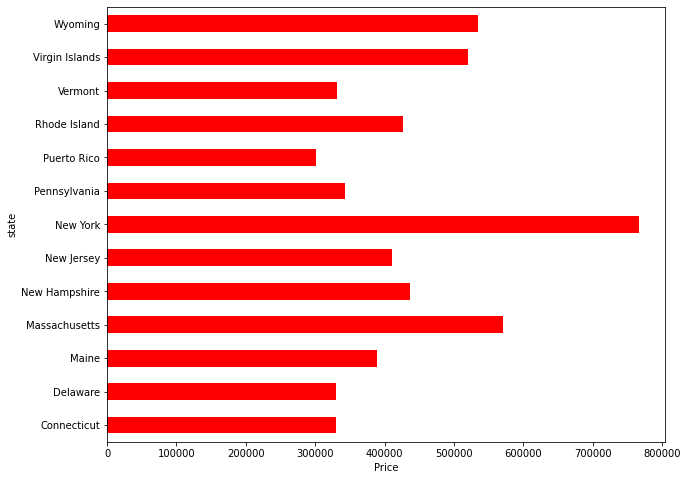

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

groupby_state.plot(kind="barh", ax=ax, color = "red")
ax.set(xlabel="Price");

In [10]:
df

,bed,bath,acre_lot,state,house_size,price
3,4.0,2.0,0.10,Puerto Rico,1800.0,145000.0
5,4.0,3.0,0.46,Puerto Rico,2520.0,179000.0
11,3.0,2.0,0.08,Puerto Rico,1045.0,150000.0
22,3.0,1.0,2.00,Puerto Rico,1213.0,189000.0
25,3.0,2.0,0.28,Puerto Rico,1500.0,255000.0
...,...,...,...,...,...,...
904904,3.0,2.0,0.34,New York,1560.0,690000.0
904907,3.0,4.0,0.15,New York,2600.0,749900.0
904908,3.0,4.0,1.63,New York,2688.0,1475000.0
904916,3.0,3.0,2.03,New York,2182.0,899000.0


In [11]:
### Checking the percentage of  number of missing values in each column

In [12]:
df.isnull().sum()/len(df) * 100

bed           0.0
bath          0.0
acre_lot      0.0
state         0.0
house_size    0.0
price         0.0
dtype: float64

In [13]:
## Checking the cardinality 

In [14]:
df.nunique()

bed              3
bath             4
acre_lot       203
state           13
house_size    1764
price         2060
dtype: int64

In [15]:
## Checking if there is a correlation between the Features and price

In [16]:
corr = df.head().corr()
corr

,bed,bath,acre_lot,house_size,price
bed,1.000000,0.645497,-0.344138,0.854500,-0.447467
bath,0.645497,1.000000,-0.675189,0.794539,-0.080233
acre_lot,-0.344138,-0.675189,1.000000,-0.239211,0.155679
house_size,0.854500,0.794539,-0.239211,1.000000,-0.024717
price,-0.447467,-0.080233,0.155679,-0.024717,1.000000


In [17]:
corr = df.select_dtypes("number").head().corr()
corr

,bed,bath,acre_lot,house_size,price
bed,1.000000,0.645497,-0.344138,0.854500,-0.447467
bath,0.645497,1.000000,-0.675189,0.794539,-0.080233
acre_lot,-0.344138,-0.675189,1.000000,-0.239211,0.155679
house_size,0.854500,0.794539,-0.239211,1.000000,-0.024717
price,-0.447467,-0.080233,0.155679,-0.024717,1.000000


<Axes: >

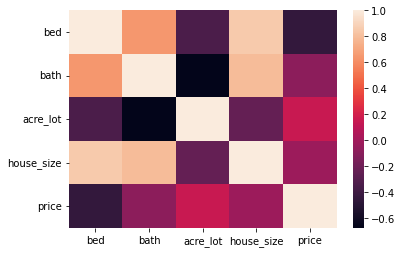

In [18]:
import seaborn as sns
sns.heatmap(corr)

In [19]:
df.select_dtypes("number").nunique()

bed              3
bath             4
acre_lot       203
house_size    1764
price         2060
dtype: int64

In [20]:
df

,bed,bath,acre_lot,state,house_size,price
3,4.0,2.0,0.10,Puerto Rico,1800.0,145000.0
5,4.0,3.0,0.46,Puerto Rico,2520.0,179000.0
11,3.0,2.0,0.08,Puerto Rico,1045.0,150000.0
22,3.0,1.0,2.00,Puerto Rico,1213.0,189000.0
25,3.0,2.0,0.28,Puerto Rico,1500.0,255000.0
...,...,...,...,...,...,...
904904,3.0,2.0,0.34,New York,1560.0,690000.0
904907,3.0,4.0,0.15,New York,2600.0,749900.0
904908,3.0,4.0,1.63,New York,2688.0,1475000.0
904916,3.0,3.0,2.03,New York,2182.0,899000.0


In [194]:
##Dealing with the missing values

<Axes: >

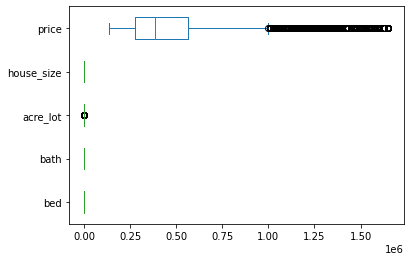

In [21]:
df.plot(kind="box", vert=False)

<Axes: >

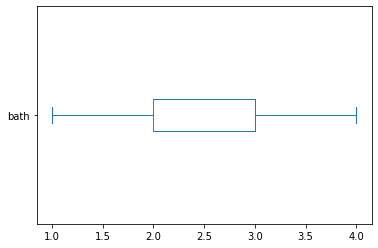

In [22]:
df["bath"].plot(kind="box", vert=False)

<Axes: >

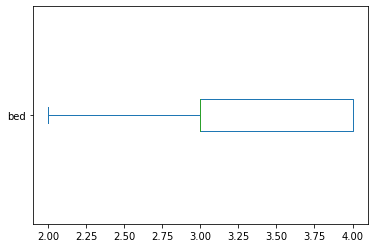

In [23]:
df["bed"].plot(kind="box", vert=False)

<Axes: >

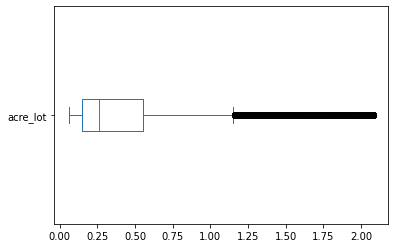

In [24]:
df["acre_lot"].plot(kind="box", vert=False)

In [25]:
df.isna().sum()

bed           0
bath          0
acre_lot      0
state         0
house_size    0
price         0
dtype: int64

## Spliting the Data into X feature matrice and y column vector

In [27]:
X = df.drop(columns = ["price"])
y = df["price"]

In [28]:
## Spliting the Data into X_train X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# Build Model

In [46]:
y_base_Line = [y_train.mean()]*len(y_train)
y_baseline_mae = mean_absolute_error(y_train,y_base_Line)
y_baseline_mae
print("The baseline mean value of the price is",round(y_train.mean(), 2))
print("The baseline mean absolute error of the price is",y_baseline_mae.round(2))

The baseline mean value of the price is 450976.77
The baseline mean absolute error of the price is 187684.76


## Iterate

In [49]:
model = make_pipeline(
    OneHotEncoder(),
    SGDRegressor()

)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('sgdregressor', SGDRegressor())])

In [54]:
y_pred = model.predict(X_train)

mean_abs_err = mean_absolute_error(y_train,y_pred)
print("The Mean Absolute Error is ",mean_abs_err)

The MAE is  123222.99533351147


In [56]:
model.fit(X_test, y_test)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('sgdregressor', SGDRegressor())])

In [59]:
y_pred_Test = pd.Series(model.predict(X_test))
y_pred_Test

0        404714.495687
1        503837.962712
2        452991.472454
3        355708.719733
4        453129.345753
             ...      
36462    413839.528981
36463    288984.014319
36464    503200.823860
36465    389675.742775
36466    319556.856018
Length: 36467, dtype: float64

In [60]:
df

,bed,bath,acre_lot,state,house_size,price
3,4.0,2.0,0.10,Puerto Rico,1800.0,145000.0
5,4.0,3.0,0.46,Puerto Rico,2520.0,179000.0
11,3.0,2.0,0.08,Puerto Rico,1045.0,150000.0
22,3.0,1.0,2.00,Puerto Rico,1213.0,189000.0
25,3.0,2.0,0.28,Puerto Rico,1500.0,255000.0
...,...,...,...,...,...,...
904904,3.0,2.0,0.34,New York,1560.0,690000.0
904907,3.0,4.0,0.15,New York,2600.0,749900.0
904908,3.0,4.0,1.63,New York,2688.0,1475000.0
904916,3.0,3.0,2.03,New York,2182.0,899000.0


## Communicating Our Results to Stakeholders

In [116]:
feature_names = model.named_steps['onehotencoder'].get_feature_names_out()

In [117]:
feature_names

array(['bed_2.0', 'bed_3.0', 'bed_4.0', ..., 'house_size_2748.0',
       'house_size_2749.0', 'house_size_2750.0'], dtype=object)

In [122]:
coefficients = model.named_steps['sgdregressor'].coef_
coefficients

array([240656.06497932, 218133.5768911 , 213162.11164851, ...,
       -30143.47026052, -27541.02583831,  81030.4356907 ])

In [124]:
feat_imp = pd.Series(coefficients, index = feature_names )
len(feat_imp)

1959

<Axes: >

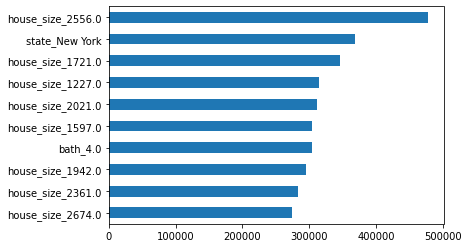

In [127]:
feat_imp.sort_values(key=abs).tail(10).plot(kind ='barh')

In [74]:
def make_prediction(bed, bath, acre_lot,state, house_size):
    data = {
        "bed": bed,
        "bath" : bath,
        "acre_lot" : acre_lot,
        "state" : state ,
        "house_size":house_size
              
    }
    df = pd.DataFrame(data, index=[0])
    
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [77]:
make_prediction(2, 2, 0.1, "Puerto Rico",1800)

'Predicted apartment price: $295730.74'

In [82]:
states = df["state"].unique()

In [85]:
for state in states:
    price_by_state =make_prediction(2, 2, 0.1, state,1800)
    print(price_by_state)

Predicted apartment price: $295730.74
Predicted apartment price: $388395.32
Predicted apartment price: $589988.09
Predicted apartment price: $359734.18
Predicted apartment price: $413843.4
Predicted apartment price: $449799.7
Predicted apartment price: $364997.65
Predicted apartment price: $742161.86
Predicted apartment price: $459751.85
Predicted apartment price: $379581.43
Predicted apartment price: $426780.49
Predicted apartment price: $347404.71
Predicted apartment price: $314564.71


In [86]:
df

,bed,bath,acre_lot,state,house_size,price
3,4.0,2.0,0.10,Puerto Rico,1800.0,145000.0
5,4.0,3.0,0.46,Puerto Rico,2520.0,179000.0
11,3.0,2.0,0.08,Puerto Rico,1045.0,150000.0
22,3.0,1.0,2.00,Puerto Rico,1213.0,189000.0
25,3.0,2.0,0.28,Puerto Rico,1500.0,255000.0
...,...,...,...,...,...,...
904904,3.0,2.0,0.34,New York,1560.0,690000.0
904907,3.0,4.0,0.15,New York,2600.0,749900.0
904908,3.0,4.0,1.63,New York,2688.0,1475000.0
904916,3.0,3.0,2.03,New York,2182.0,899000.0


In [91]:
X_train

,bed,bath,acre_lot,state,house_size
409157,3.0,2.0,0.46,Massachusetts,1747.0
608788,4.0,4.0,0.46,New Jersey,1972.0
37541,2.0,1.0,1.05,Massachusetts,1768.0
415351,3.0,2.0,0.28,Connecticut,1357.0
699560,2.0,2.0,0.10,New Jersey,1118.0
...,...,...,...,...,...
388962,3.0,3.0,0.86,Connecticut,1212.0
685856,3.0,1.0,0.21,New Jersey,1169.0
61555,3.0,2.0,0.18,Connecticut,1378.0
640685,3.0,2.0,0.26,Delaware,1225.0


In [107]:
import ipywidgets as widgets

In [129]:
interact(
    make_prediction,
    acre_lot=FloatSlider(
        min=X_train["acre_lot"].min(),
        max=X_train["acre_lot"].max(),
        value=round(X_train["acre_lot"].mean(),2),
    ),
    bed=widgets.IntSlider(
        min=X_train["bed"].min(),
        max=X_train["bed"].max(),
        step=1,
        value=(X_train["bed"].mean()),
    ),
    bath=widgets.IntSlider(
        min=X_train["bath"].min(),
        max=X_train["bath"].max(),
        step=1,
        value=(X_train["bath"].mean()),
    ),

    state=Dropdown(options=sorted(X_train["state"].unique())),
    
    
    house_size=FloatSlider(
    min=X_train["house_size"].min(),
    max=X_train["house_size"].max(),
    step=1,
    value=round(X_train["house_size"].mean()),
    ),
);

interactive(children=(IntSlider(value=3, description='bed', max=4, min=2), IntSlider(value=2, description='bat…